# init

In [1]:
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
import difflib
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
from typing import List, Tuple, Dict, Any

seed = 18022004
np.random.seed(seed)

/drive2/phatnt/zTrans/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data_prefix: str = 'data'
repo_prefix: str = f'{data_prefix}/repos'

model_id: str = 'deepseek-ai/deepseek-coder-6.7b-instruct'

# statistics

## init data

In [17]:
# data_name = 'ori_data_method_treesitter.parquet'
data_name = 'ori_data_method_treesitter_filtered_special.parquet'

data_df: pd.DataFrame = pd.read_parquet(f'{data_prefix}/{data_name}', engine = 'pyarrow')

# statistics

* special cases

group by migration:
- number of classes
-  number of methods

group by class:
- number of methods (add, remove, total)
- number of lines (add, remove, total)

group by method:
- number of lines (add, remove, total)
- number of tokens (add, remove, total)

## data filter (done)

In [55]:
# print(len(data_df))

81804


In [67]:
# remove all special cases
# special cases are neither methods_before nor methods_after is blank
# filtered_df: pd.DataFrame = data_df[data_df['method_before'].str.len() > 0]
# print(len(filtered_df))
# filtered_df: pd.DataFrame = filtered_df[filtered_df['method_after'].str.len() > 0]
# print(len(filtered_df))
# filtered_df.reset_index(drop = True, inplace = True)
# filtered_df['id'] = filtered_df.index

56006
38393


In [68]:
# filtered_df.to_parquet(f'{data_prefix}/ori_data_method_treesitter_filtered_special.parquet', engine = 'pyarrow')

In [66]:
# print(filtered_df.iloc[0]['method_name'])
# print('-' * 100)
# print(filtered_df.iloc[0]['startCode_cleaned'])
# print('-' * 100)
# print(filtered_df.iloc[0]['endCode_cleaned'])

## by migration

## by class

## by method

### process

In [43]:
data_df['added'] = None
data_df['removed'] = None

data_df['method_before_token'] = None
data_df['method_after_token'] = None
data_df['method_before_line'] = None
data_df['method_after_line'] = None

data_df['added_token'] = None
data_df['removed_token'] = None
data_df['added_line'] = None
data_df['removed_line'] = None

data_df['changed_token'] = None
data_df['changed_line'] = None

In [9]:
def build_tokenizer(model_id: str = model_id) -> AutoTokenizer:
    tokenizer: AutoTokenizer = AutoTokenizer.from_pretrained(model_id, trust_remote_code = True,)

    return tokenizer

tokenizer: AutoTokenizer = build_tokenizer(model_id = model_id)

In [24]:
from threading import Thread

def get_diff(string1: str, string2: str) -> str:
    # Normalize by removing leading/trailing whitespace and replacing tabs with spaces
    normalized1: List[str] = [line.strip().replace('\t', '') for line in string1.splitlines()]
    normalized2: List[str] = [line.strip().replace('\t', '') for line in string2.splitlines()]

    # Generate the diff
    diff: str = difflib.unified_diff(
        normalized1,
        normalized2,
        lineterm = ''
    )
    return '\n'.join(diff)

def extract_diff_changes(diff_str: str) -> Tuple[List[str], List[str], str, str]:
    added_lines: List[str] = []
    removed_lines: List[str] = []

    # Split the diff into lines
    lines: List[str] = diff_str.splitlines()

    # Iterate through the lines
    for line in lines:
        if line.startswith('+') and not line.startswith('+++'):
            # Line added (exclude the '+++' line indicating the file name)
            added_lines.append(line[1:].strip())
        elif line.startswith('-') and not line.startswith('---'):
            # Line removed (exclude the '---' line indicating the file name)
            removed_lines.append(line[1:].strip())

    # Join the lines with '\n'
    added_str: str = '\n'.join(added_lines)
    removed_str: str = '\n'.join(removed_lines)

    return added_lines, removed_lines, added_str, removed_str

def get_token_count(tokenizer: AutoTokenizer, text: str) -> List[int]:
    return len(tokenizer.encode(text, return_tensors = 'pt').to('cpu')[0])

output: Dict = {}

class get_data_by_thread(Thread):
    def __init__(self, sample: pd.DataFrame, id: int, tokenizer: AutoTokenizer) -> None:
        Thread.__init__(self)
        self.sample = sample
        self.id = id
        self.tokenizer = tokenizer

    def run(self) -> None:
        id: int = self.sample['id']
        sample: pd.DataFrame = self.sample
        tokenizer: AutoTokenizer = self.tokenizer

        method_before: str = self.sample['method_before']
        method_after: str = self.sample['method_after']

        method_before_line: int = len(method_before.split('\n'))
        method_after_line: int = len(method_after.split('\n'))

        method_before_token_count: int = get_token_count(tokenizer = tokenizer, text = method_before)
        method_after_token_count: int = get_token_count(tokenizer = tokenizer, text = method_after)

        diff: str = sample['method_diff']
        added_lines, removed_lines, added_str, removed_str = extract_diff_changes(diff)
        added_str_token_count: int = get_token_count(tokenizer = tokenizer, text = added_str)
        removed_str_token_count: int = get_token_count(tokenizer = tokenizer, text = removed_str)

        changed_token: int = added_str_token_count + removed_str_token_count
        changed_line: int = max(len(added_lines), len(removed_lines))

        output[id] = {
            'added': added_str,
            'removed': removed_str,

            'method_before_token_count': method_before_token_count,
            'method_after_token_count': method_after_token_count,
            'method_before_line': method_before_line,
            'method_after_line': method_after_line,

            'added_token': added_str_token_count,
            'removed_token': removed_str_token_count,
            'added_line': len(added_lines),
            'removed_line': len(removed_lines),

            'changed_token': changed_token,
            'changed_line': changed_line,
        }

In [ ]:
def method_statistics_single_thread(data_df: pd.DataFrame) -> pd.DataFrame:
    for id in tqdm(range(len(data_df)), desc = 'Processing method', total = len(data_df)):
        sample = data_df.iloc[id]

        # init
        method_before = sample['method_before']
        method_after = sample['method_after']

        method_before_lines = method_before.split('\n')
        method_after_lines = method_after.split('\n')

        method_before_token_count = get_token_count(tokenizer, method_before)
        method_after_token_count = get_token_count(tokenizer, method_after)

        diff = sample['method_diff']
        added_lines, removed_lines, added_str, removed_str = extract_diff_changes(diff)
        # added_lines_tokens = [get_token_count(tokenizer, line) for line in added_lines]
        # removed_lines_tokens = [get_token_count(tokenizer, line) for line in removed_lines]
        added_str_token_count = get_token_count(tokenizer, added_str)
        removed_str_token_count = get_token_count(tokenizer, removed_str)

        # print(method_before_token_count, method_after_token_count, added_str_token_count, removed_str_token_count)

        # add to the df
        data_df.at[id, 'added'] = added_str
        data_df.at[id, 'removed'] = removed_str

        data_df.at[id, 'method_before_token'] = method_before_token_count
        data_df.at[id, 'method_after_token'] = method_after_token_count
        data_df.at[id, 'method_before_line'] = len(method_before_lines)
        data_df.at[id, 'method_after_line'] = len(method_after_lines)

        data_df.at[id, 'added_token'] = added_str_token_count
        data_df.at[id, 'removed_token'] = removed_str_token_count
        data_df.at[id, 'added_line'] = len(added_lines)
        data_df.at[id, 'removed_line'] = len(removed_lines)

        data_df.at[id, 'changed_token'] = added_str_token_count + removed_str_token_count
        data_df.at[id, 'changed_line'] = max(len(added_lines), len(removed_lines))

    return data_df

def method_statistics_multi_thread(data_df: pd.DataFrame) -> pd.DataFrame:
    threads = []
    thread_cnt = 20

    for id in tqdm(range(len(data_df)), desc = 'Processing method', total = len(data_df)):
        sample = data_df.iloc[id]
        thread = get_data_by_thread(sample = sample)
        thread.start()
        threads.append(thread)

        if ((id + 1) % thread_cnt == 0 or id == len(data_df) - 1):
            # for thread in threads:
            #     thread.start()
            for thread in threads:
                thread.join()

            for sample_id in output.keys():
                data_df.at[sample_id, 'added'] = output[sample_id]['added']
                data_df.at[sample_id, 'removed'] = output[sample_id]['removed']

                data_df.at[sample_id, 'method_before_token'] = output[sample_id]['method_before_token_count']
                data_df.at[sample_id, 'method_after_token'] = output[sample_id]['method_after_token_count']
                data_df.at[sample_id, 'method_before_line'] = output[sample_id]['method_before_line']
                data_df.at[sample_id, 'method_after_line'] = output[sample_id]['method_after_line']

                data_df.at[sample_id, 'added_token'] = output[sample_id]['added_str_token_count']
                data_df.at[sample_id, 'removed_token'] = output[sample_id]['removed_str_token_count']
                data_df.at[sample_id, 'added_line'] = output[sample_id]['added_line']
                data_df.at[sample_id, 'removed_line'] = output[sample_id]['removed_line']

                data_df.at[sample_id, 'changed_token'] = output[sample_id]['changed_token']
                data_df.at[sample_id, 'changed_line'] = output[sample_id]['changed_line']

    return data_df

last_df = method_statistics_multi_thread(data_df = data_df)

last_df.to_parquet(f'{data_prefix}/phat_filtered_method.parquet', engine = 'pyarrow')

### visualization

In [61]:
data_df = pd.read_parquet(f'{data_prefix}/phat_filtered_method.parquet', engine = 'pyarrow')

In [18]:
data_df.columns

Index(['id', 'fromLib', 'toLib', 'repoName', 'prevCommit', 'startCommit',
       'endCommit', 'fileName', 'startCommitChanges', 'endCommitChanges',
       'startCode_cleaned', 'endCode_cleaned', 'method_before', 'method_after',
       'method_diff', 'method_name', 'method_signature', 'added', 'removed',
       'method_before_token', 'method_after_token', 'method_before_line',
       'method_after_line', 'added_token', 'removed_token', 'added_line',
       'removed_line', 'changed_token', 'changed_line'],
      dtype='object')

In [65]:
import matplotlib.pyplot as plt

# Type aliases
# Numeric = Union[int, float]

def plot_column_by_bins(df: pd.DataFrame, column, col_min: int = 0, col_max: int = -1, bins: int = 10) -> None:
    """
    Plot a histogram of a specified DataFrame column, grouped by bins.

    Parameters:
        df (pd.DataFrame): The DataFrame containing the data.
        column (str): The column name to plot.
        bins (int): The number of bins for grouping values. Default is 10.

    Returns:
        None
    """

    if column not in df.columns:
        raise ValueError(f"Column '{column}' not found in DataFrame.")
    if not pd.api.types.is_numeric_dtype(df[column]):
        raise ValueError(f"Column '{column}' must contain numeric data.")

    if (col_min > col_max):
        col_min, col_max = df[column].min(), df[column].max()

    # Plot the histogram with bin limits
    plt.hist(df[column], bins = bins, range = (col_min, col_max), edgecolor = 'k', alpha = 0.7)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.show()

method_before_token


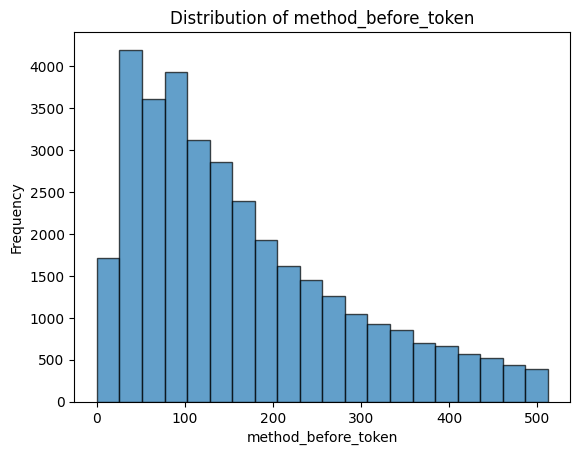

method_before_token >= 512: 0.11030656630114864
count    38393.000000
mean       251.018180
std        448.632371
min         10.000000
25%         77.000000
50%        151.000000
75%        300.000000
max      55320.000000
Name: method_before_token, dtype: float64
----------------------------------------------------------------------------------------------------
method_after_token


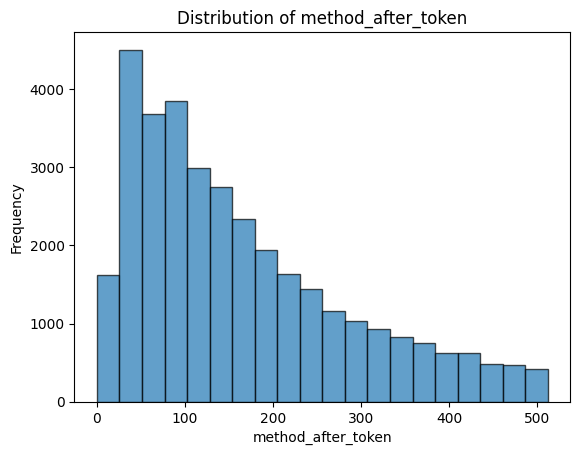

method_after_token >= 512: 0.11168702628083245
count    38393.000000
mean       254.100461
std        457.286815
min          7.000000
25%         75.000000
50%        151.000000
75%        303.000000
max      55348.000000
Name: method_after_token, dtype: float64
----------------------------------------------------------------------------------------------------
added_token


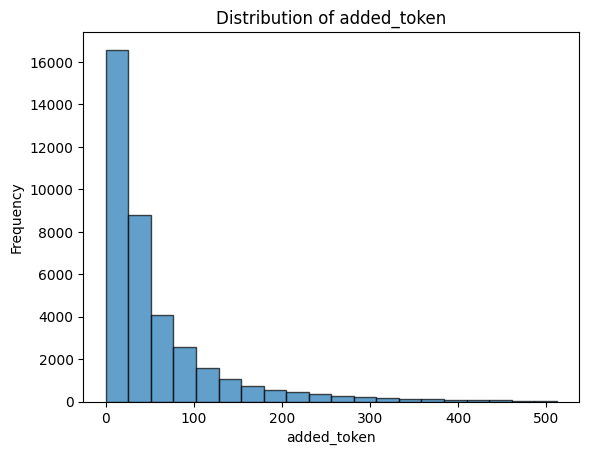

added_token >= 512: 0.012241814914177064
count    38393.000000
mean        67.318079
std        133.809088
min          1.000000
25%         15.000000
50%         31.000000
75%         72.000000
max       6852.000000
Name: added_token, dtype: float64
----------------------------------------------------------------------------------------------------
removed_token


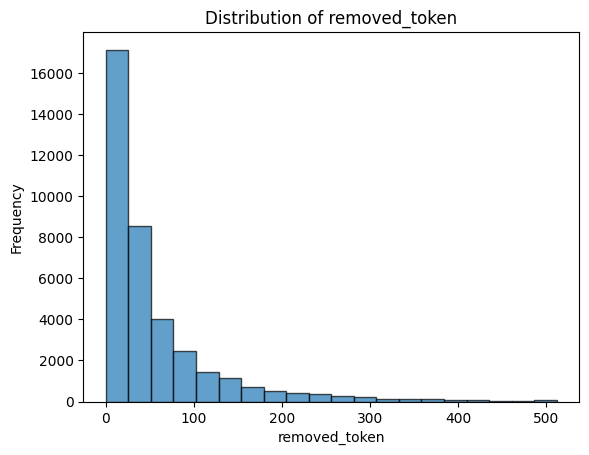

removed_token >= 512: 0.010210194566717892
count    38393.000000
mean        64.298804
std        122.540520
min          1.000000
25%         14.000000
50%         30.000000
75%         69.000000
max       6728.000000
Name: removed_token, dtype: float64
----------------------------------------------------------------------------------------------------
changed_token


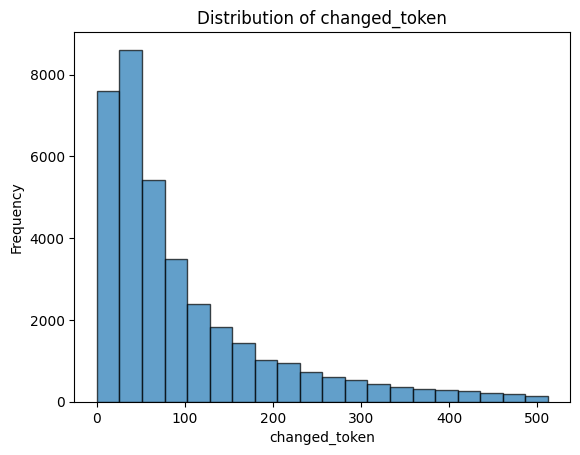

changed_token >= 512: 0.04250774880837653
count    38393.000000
mean       131.616883
std        230.443054
min          2.000000
25%         31.000000
50%         64.000000
75%        145.000000
max      13580.000000
Name: changed_token, dtype: float64
----------------------------------------------------------------------------------------------------
method_before_line


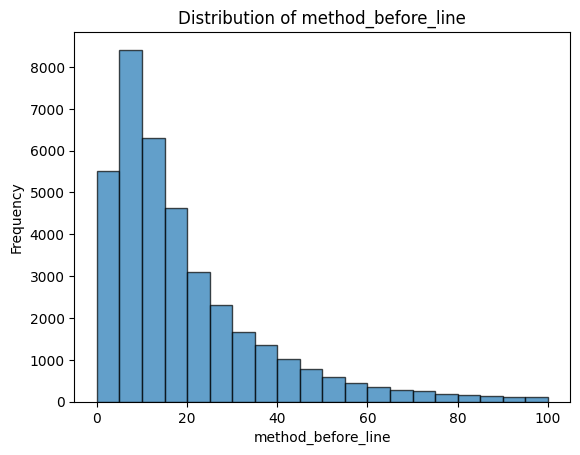

method_before_line >= 100: 0.01937853254499518
count    38393.000000
mean        21.837496
std         33.398695
min          1.000000
25%          7.000000
50%         14.000000
75%         26.000000
max       3335.000000
Name: method_before_line, dtype: float64
----------------------------------------------------------------------------------------------------
method_after_line


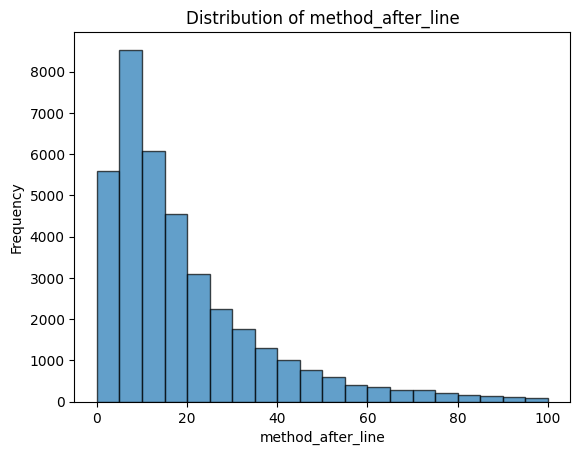

method_after_line >= 100: 0.020837131768812023
count    38393.000000
mean        22.078009
std         34.124712
min          1.000000
25%          7.000000
50%         14.000000
75%         26.000000
max       3336.000000
Name: method_after_line, dtype: float64
----------------------------------------------------------------------------------------------------
added_line


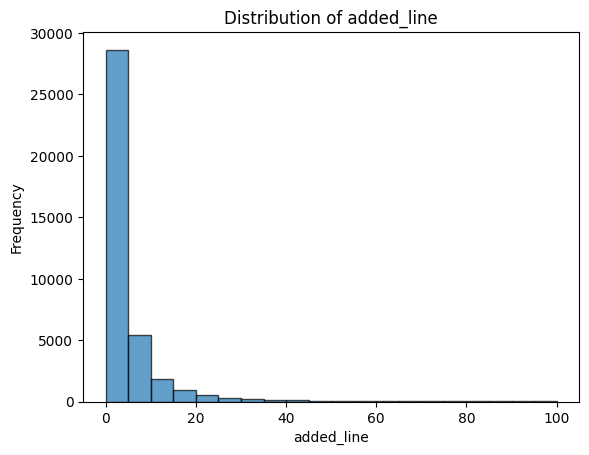

added_line >= 100: 0.0016409241267939469
count    38393.000000
mean         4.715651
std         10.555674
min          0.000000
25%          1.000000
50%          2.000000
75%          5.000000
max        384.000000
Name: added_line, dtype: float64
----------------------------------------------------------------------------------------------------
removed_line


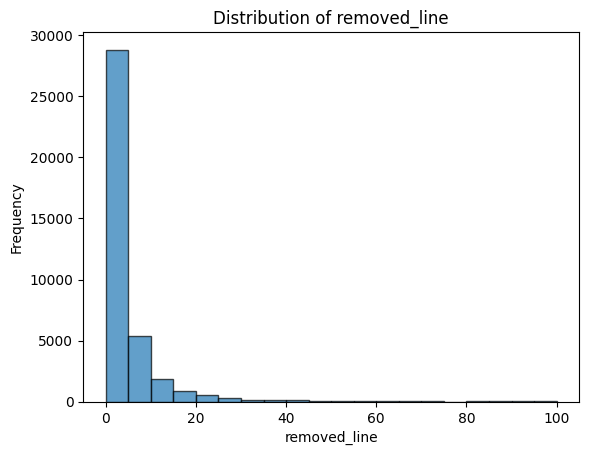

removed_line >= 100: 0.0015367384679498867
count    38393.000000
mean         4.475165
std          9.585258
min          0.000000
25%          1.000000
50%          2.000000
75%          4.000000
max        371.000000
Name: removed_line, dtype: float64
----------------------------------------------------------------------------------------------------
changed_line


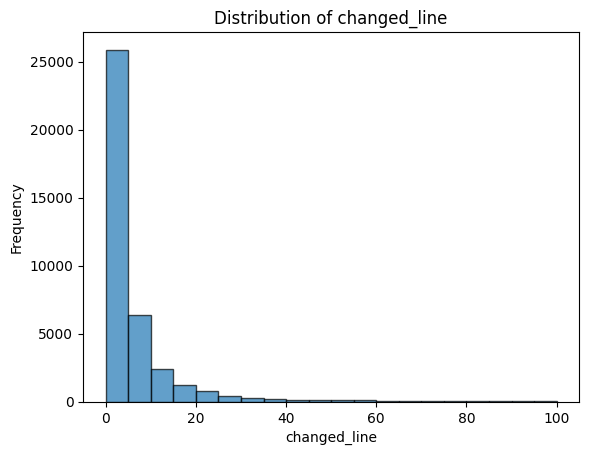

changed_line >= 100: 0.002943244862344698
count    38393.000000
mean         6.131352
std         12.962953
min          0.000000
25%          1.000000
50%          2.000000
75%          6.000000
max        384.000000
Name: changed_line, dtype: float64
----------------------------------------------------------------------------------------------------


In [78]:
method_columns = [
    'method_before_token',
    'method_after_token',

    'added_token',
    'removed_token',

    'changed_token',

    'method_before_line',
    'method_after_line',

    'added_line',
    'removed_line',

    'changed_line',
]

max_line = 100
max_token = 512

for column in method_columns:
    print(column)
    if (column.endswith('line')):
        plot_column_by_bins(data_df, column, col_max = max_line, bins = 20)
        print(f'{column} >= {max_line}: {len(data_df[data_df[column] > max_line]) / len(data_df)}')
    else:
        plot_column_by_bins(data_df, column, col_max = max_token, bins = 20)
        print(f'{column} >= {max_token}: {len(data_df[data_df[column] > max_token]) / len(data_df)}')
    print(data_df[column].describe())
    print('-' * 100)